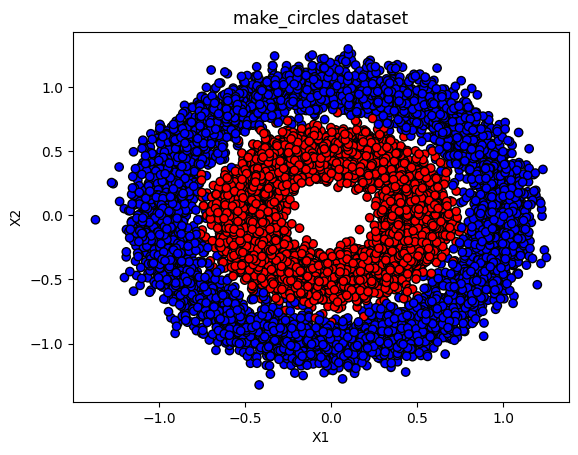

In [10]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Generate 2D circular dataset
X, y = make_circles(n_samples=10000,      # total number of points
                    factor=0.5,        # scale factor between inner and outer circle
                    noise=0.1,        # standard deviation of Gaussian noise
                    random_state=42)
# Plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("make_circles dataset")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
import tensorflow as tf
import numpy as np

class Data:
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

def DataLoader(dataset, batch_size=64, shuffle=True):
    indices = np.arange(len(dataset))
    if shuffle:
        np.random.shuffle(indices)

    for start_idx in range(0, len(dataset), batch_size):
        batch_indices = indices[start_idx:start_idx+batch_size]
        batch_X = np.array([dataset[i][0] for i in batch_indices])
        batch_y = np.array([dataset[i][1] for i in batch_indices])
        yield batch_X, batch_y

# ----------------------
# Usage
batch_size = 64

train_data = Data(X_train, y_train)
test_data = Data(X_test, y_test)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Iterate over one batch
for batch, (X, y) in enumerate(train_dataloader):
    print(f'Batch: {batch+1}')
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')
    break


Batch: 1
X shape: (64, 2)
y shape: (64,)


In [13]:
import tensorflow as tf

input_dim = 2
hidden_dim = 10
output_dim = 1

class NeuralNetwork(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # Layers without activation
        self.layer_1 = tf.keras.layers.Dense(
            hidden_dim,
            activation=None,  # No activation here
            kernel_initializer=tf.keras.initializers.HeUniform()
        )
        self.layer_2 = tf.keras.layers.Dense(
            output_dim,
            activation=None  # No activation here
        )

    def call(self, x):
        # Apply activations manually, same as PyTorch
        x = tf.nn.relu(self.layer_1(x))
        x = tf.nn.sigmoid(self.layer_2(x))
        return x

# --------------------------
# Instantiate and test
# --------------------------
model = NeuralNetwork(input_dim, hidden_dim, output_dim)

dummy_input = tf.random.normal((1, input_dim))
output = model(dummy_input)
print("Output:", output.numpy())

# Count total parameters
total_params = sum([tf.size(v).numpy() for v in model.trainable_variables])
print("Total number of parameters:", total_params)


Output: [[0.42945457]]
Total number of parameters: 41


In [14]:
learning_rate = 0.1

# Binary Cross-Entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

# SGD optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)


In [15]:
num_epochs = 100
loss_values = []

for epoch in range(num_epochs):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    for X, y in train_dataloader:
        # --------------------------
        # Forward + backward + optimization
        # --------------------------
        with tf.GradientTape() as tape:
            pred = model(X, training=True)              # forward pass
            loss = loss_fn(y.reshape(-1, 1), pred)     # compute loss

        grads = tape.gradient(loss, model.trainable_variables)   # backward
        optimizer.apply_gradients(zip(grads, model.trainable_variables))  # step

        # store loss
        loss_values.append(loss.numpy())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.numpy():.4f}")

print('Training Complete')

Epoch 10, Loss: 0.0865
Epoch 20, Loss: 0.0507
Epoch 30, Loss: 0.0283
Epoch 40, Loss: 0.0214
Epoch 50, Loss: 0.0250
Epoch 60, Loss: 0.0191
Epoch 70, Loss: 0.0188
Epoch 80, Loss: 0.0118
Epoch 90, Loss: 0.0073
Epoch 100, Loss: 0.0062
Training Complete


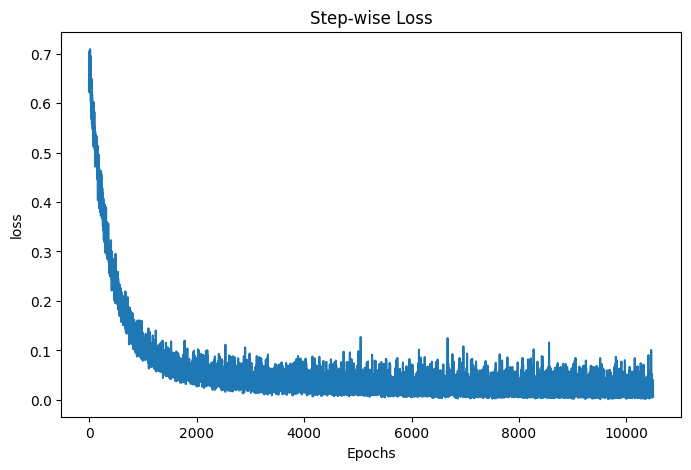

In [16]:
step = range(len(loss_values))

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title('Step-wise Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [17]:
y_pred = []
y_test = []
correct = 0
total = 0

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

for X, y in test_dataloader:
    outputs = model(X, training=False).numpy()           # forward pass
    predicted = (outputs >= 0.5).astype(int).reshape(-1) # threshold at 0.5

    # collect predictions and true labels
    y_pred.extend(predicted.tolist())
    y_test.extend(y.tolist())

    # count correct predictions
    correct += (predicted == y).sum()
    total += y.shape[0]

print(f'Accuracy of the network on the {total} test instances: {100 * correct / total:.2f}%')


Accuracy of the network on the 3300 test instances: 99.15%
